# Libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(6,4))
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [52]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Analysis and Loading

In [2]:
raw_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [5]:
raw_df.question_text.sample(10).values[:5]

array(['What are the process of socialization?', 'What is an Adonis?',
       "What is a 'killer robot'?",
       'What do Indians think of Filipino s?',
       'Is it normal seeing a girl wearing a hijab and getting drunk as well as wearing short clothes on?'],
      dtype=object)

In [6]:
test_df.question_text.sample(10).values[:5]

array(['How do you experience intimate and emotional love having NPD?',
       'Why monsoon winds change their direction after six months?',
       'Could offroad driving cause subconcussive damage through a bumpy ride?',
       'How China use tanks to run over college students in 1989?',
       'Whose boobs have been seen by the most people?'], dtype=object)

In [7]:
sample_size=100_000
sample_df=raw_df.sample(sample_size)

In [8]:
sample_df.question_text.sample(10).values[:5]

array(['As a teacher, how awkward is it when a student discovers your Quora account?',
       'How does one become a transport economist with a BTech (Civil Engineering) in India?',
       'What do people mean by saying "I can\'t breathe"?',
       "How good is the Men's Volleyball team at UIUC?",
       "What happens to magma as it rises through the Earth's mantle?"],
      dtype=object)

In [9]:
sample_df.target.value_counts(normalize=True)

target
0    0.9385
1    0.0615
Name: proportion, dtype: float64

# Preprocessing

## TF-IDF Vectorization

In [13]:
word_tokenize("testing, a lot, of punctuations!!")

['testing', ',', 'a', 'lot', ',', 'of', 'punctuations', '!', '!']

In [15]:
stemmer= SnowballStemmer(language='english')

In [17]:
stemmer.stem("butterflies"), stemmer.stem("doing"), stemmer.stem("really")

('butterfli', 'do', 'realli')

In [18]:
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]

In [20]:
tokenize("testing tokenizer, really good enough!")

['test', 'token', ',', 'realli', 'good', 'enough', '!']

In [22]:
english_stopwords= stopwords.words('english')

In [23]:
vectorizer= TfidfVectorizer(tokenizer=tokenize,
                            stop_words=english_stopwords, max_features=1000)

In [25]:
%%time
vectorizer.fit(sample_df.question_text)

c:\Users\abhin\.conda\envs\test1\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\abhin\.conda\envs\test1\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: total: 25.9 s
Wall time: 47.6 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x000001D93F846EF0>)

In [26]:
vectorizer.get_feature_names_out()[:50]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '30', '4', '5', '6', '7', '8', ':', ';', '?', '[', ']', '``',
       'abl', 'abroad', 'abus', 'accept', 'access', 'accomplish',
       'accord', 'account', 'achiev', 'acid', 'act', 'action', 'activ',
       'actor'], dtype=object)

## Transforming questions to vectors

In [27]:
%%time
input = vectorizer.transform(sample_df['question_text'])

CPU times: total: 20.8 s
Wall time: 36.3 s


In [28]:
%%time
test_input = vectorizer.transform(test_df['question_text'])

CPU times: total: 1min 35s
Wall time: 2min 34s


# Preparation for training

In [32]:
train_df, val_df, train_target, val_target= train_test_split(input, sample_df['target'], test_size=0.2)

## Converting to Pytorch Tensor

In [46]:
train_input_tensor= torch.tensor(train_df.toarray()).float()
val_input_tensor= torch.tensor(val_df.toarray()).float()

In [47]:
train_target_tensor= torch.tensor(train_target.values).float()
val_target_tensor=torch.tensor(val_target.values).float()

In [48]:
test_input_tensor= torch.tensor(test_input.toarray()).float()

## DataLoader

In [49]:
print(type(train_input_tensor))
print(type(train_target_tensor))
print(type(val_input_tensor))
print(type(val_target_tensor))
print(type(test_input_tensor))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [50]:
train_ds= TensorDataset(train_input_tensor, train_target_tensor)
val_ds= TensorDataset(val_input_tensor, val_target_tensor)
test_ds= TensorDataset(test_input_tensor)

In [51]:
train_dl= DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl= DataLoader(val_ds, batch_size=128)
test_dl= DataLoader(test_ds, batch_size=128)

# Model

In [58]:
class QuoraNet(nn.Module):
    def __init__(self):
        super(QuoraNet, self).__init__()
        self.layer1=nn.Linear(1000, 512)
        self.layer2=nn.Linear(512, 256)
        self.layer3=nn.Linear(256, 128)
        self.layer4=nn.Linear(128, 32)
        self.layer5=nn.Linear(32, 1)

    def forward(self, inputs):
        out=self.layer1(inputs)
        out= F.relu(out)
        out=self.layer2(out)
        out= F.relu(out)
        out=self.layer3(out)
        out= F.relu(out)
        out=self.layer4(out)
        out= F.relu(out)
        out=self.layer5(out)
        return out


In [59]:
model=QuoraNet()

In [63]:
for batch in train_dl:
    batch_inputs, batch_targets = batch
    print('inputs.shape:', batch_inputs.shape)
    print('targets.shape:', batch_targets.shape)
    
    batch_out = model(batch_inputs)
    print("batch_out.shape: ", batch_out.shape)


    #probability conversion
    probs = torch.sigmoid(batch_out[:,0])
    print("probs:", probs[:10])

    preds = (probs >= 0.5).int()
    print("preds: ", preds[:10])
    print("targets: ", batch_targets[:10])
    
    print('outputs', preds)
    print('accuracy', accuracy_score(batch_targets, preds))
    print('f1_score', f1_score(batch_targets, preds))

    #loss
    print("loss: ", F.binary_cross_entropy(preds.float(), batch_targets))
    break

inputs.shape: torch.Size([128, 1000])
targets.shape: torch.Size([128])
batch_out.shape:  torch.Size([128, 1])
probs: tensor([0.5185, 0.5185, 0.5184, 0.5185, 0.5184, 0.5185, 0.5183, 0.5183, 0.5184,
        0.5186], grad_fn=<SliceBackward0>)
preds:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
targets:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
outputs tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
accuracy 0.0625
f1_score 0.11764705882352941
loss:  tensor(93.7500)


In [64]:
def evaluate(model, dl):
    losses, accs, f1s = [], [], []
    for batch in dl:
        inputs, targets = batch
        out = model(inputs)
        
        probs = torch.sigmoid(out[:,0])
        loss = F.binary_cross_entropy(probs, targets.float(), weight=torch.tensor(20.))
        losses.append(loss.item())

        preds = (probs > 0.5).int()
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds)
        
        accs.append(acc)
        f1s.append(f1)

    return np.mean(losses), np.mean(accs), np.mean(f1s)

In [66]:
evaluate(model, train_dl), evaluate(model, val_dl)

((14.522373455810547, 0.061975, 0.11600682009538668),
 (14.525827110193337, 0.05961385350318471, 0.11193445117575983))

In [67]:
def fit(epochs, lr, model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            inputs, targets = batch
            out = model(inputs)
            probs = torch.sigmoid(out[:,0])
            loss = F.binary_cross_entropy(probs, 
                                          targets.float(), 
                                          weight=torch.tensor(20.))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        loss, acc, f1 = result
        print('Epoch: {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}'.format(
            epoch, loss, acc, f1))
        history.append(result)

    return history

In [69]:
model=QuoraNet()

In [70]:
history = [evaluate(model, val_dl)]

In [71]:
history+=fit(10, 0.01, model, train_dl, val_dl)

Epoch: 0; Loss: 3.1327; Accuracy: 0.9456; F1 Score: 0.3642
Epoch: 1; Loss: 2.9660; Accuracy: 0.9442; F1 Score: 0.4291
Epoch: 2; Loss: 2.9687; Accuracy: 0.9464; F1 Score: 0.4307
Epoch: 3; Loss: 3.3367; Accuracy: 0.9423; F1 Score: 0.4304
Epoch: 4; Loss: 4.2413; Accuracy: 0.9423; F1 Score: 0.4248
Epoch: 5; Loss: 4.6081; Accuracy: 0.9427; F1 Score: 0.3883
Epoch: 6; Loss: 6.1403; Accuracy: 0.9412; F1 Score: 0.3972
Epoch: 7; Loss: 5.6555; Accuracy: 0.9418; F1 Score: 0.3679
Epoch: 8; Loss: 5.7393; Accuracy: 0.9395; F1 Score: 0.3895
Epoch: 9; Loss: 5.6366; Accuracy: 0.9363; F1 Score: 0.3679


In [72]:
history+=fit(10, 0.001, model, train_dl, val_dl)

Epoch: 0; Loss: 7.3470; Accuracy: 0.9358; F1 Score: 0.3890
Epoch: 1; Loss: 8.8794; Accuracy: 0.9363; F1 Score: 0.3837
Epoch: 2; Loss: 10.8703; Accuracy: 0.9367; F1 Score: 0.3778
Epoch: 3; Loss: 14.0451; Accuracy: 0.9363; F1 Score: 0.3833
Epoch: 4; Loss: 16.7766; Accuracy: 0.9329; F1 Score: 0.3907
Epoch: 5; Loss: 20.3136; Accuracy: 0.9344; F1 Score: 0.3938
Epoch: 6; Loss: 20.0368; Accuracy: 0.9358; F1 Score: 0.3910
Epoch: 7; Loss: 20.5865; Accuracy: 0.9352; F1 Score: 0.3818
Epoch: 8; Loss: 22.0313; Accuracy: 0.9352; F1 Score: 0.3841
Epoch: 9; Loss: 21.0909; Accuracy: 0.9333; F1 Score: 0.4005


In [73]:
history+=fit(10, 0.0001, model, train_dl, val_dl)

Epoch: 0; Loss: 22.1165; Accuracy: 0.9341; F1 Score: 0.3837
Epoch: 1; Loss: 22.9482; Accuracy: 0.9338; F1 Score: 0.3862
Epoch: 2; Loss: 24.0007; Accuracy: 0.9337; F1 Score: 0.3864
Epoch: 3; Loss: 24.5126; Accuracy: 0.9338; F1 Score: 0.3876
Epoch: 4; Loss: 25.5865; Accuracy: 0.9334; F1 Score: 0.3930
Epoch: 5; Loss: 26.2113; Accuracy: 0.9334; F1 Score: 0.3898
Epoch: 6; Loss: 27.3004; Accuracy: 0.9329; F1 Score: 0.3889
Epoch: 7; Loss: 28.1259; Accuracy: 0.9333; F1 Score: 0.3888
Epoch: 8; Loss: 29.6093; Accuracy: 0.9327; F1 Score: 0.3914
Epoch: 9; Loss: 30.0762; Accuracy: 0.9325; F1 Score: 0.3877


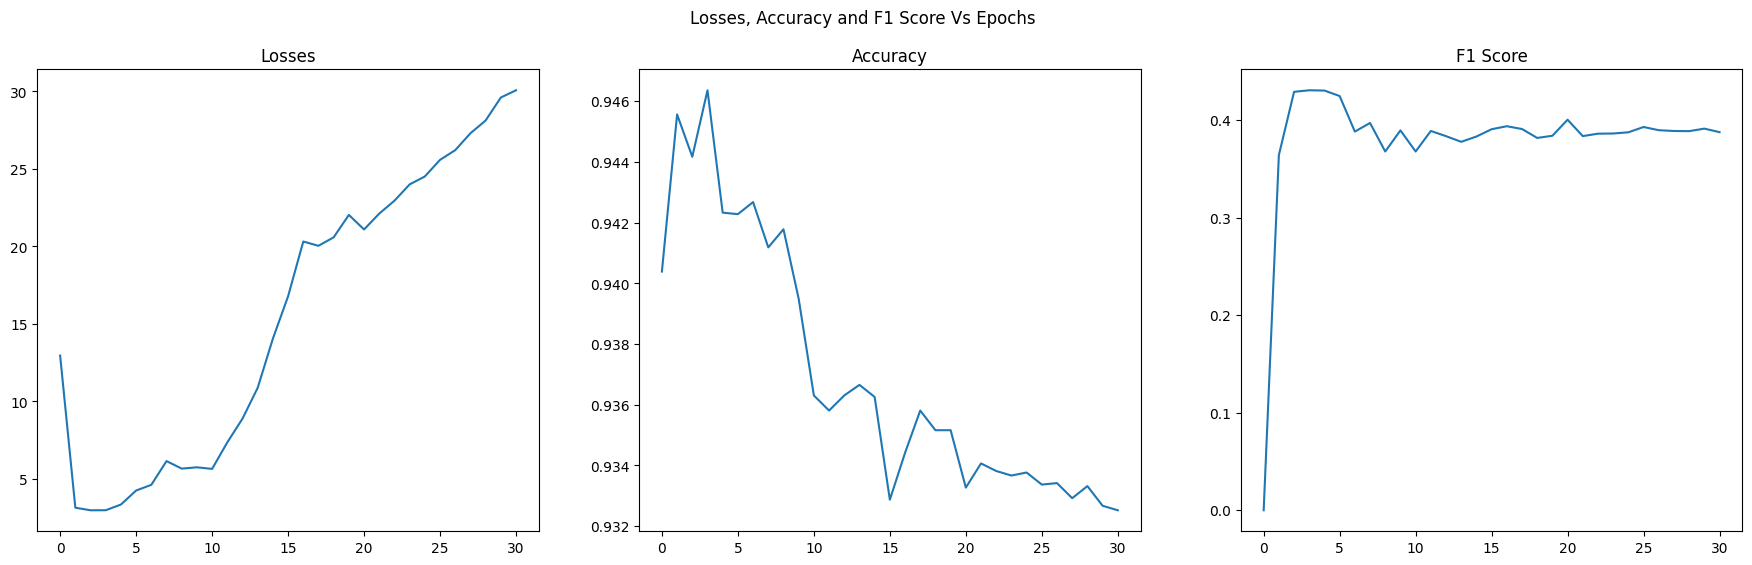

In [82]:
losses = [item[0] for item in history]
acc=[item[1] for item in history]
f1s = [item[2] for item in history]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
fig.suptitle('Losses, Accuracy and F1 Score Vs Epochs')

sns.lineplot(losses, ax=axes[0])
axes[0].set_title('Losses')
sns.lineplot(acc, ax=axes[1])
axes[1].set_title('Accuracy')
sns.lineplot(f1s, ax=axes[2])
axes[2].set_title('F1 Score')
plt.show()

# Predictions on Kaggle Data

In [136]:
test_tensors = torch.tensor(test_input.toarray()).float()

In [137]:
test_ds = TensorDataset(test_tensors)
test_dl = DataLoader(test_ds, batch_size=128)

In [138]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [140]:
test_preds = predict(model, test_dl)

In [141]:
test_preds[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [142]:
sub_df=pd.read_csv('sample_submission.csv')

In [144]:
sub_df.prediction = test_preds
sub_df.to_csv('submission.csv', index=None)